In [7]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pynq
import time
from pynq import MMIO, Overlay, allocate

In [ ]:
### TODO: Load the overlay (conv_system.bit)
ol = Overlay("conv_system.bit", download=True)

In [9]:
ol.ip_dict.keys()

dict_keys(['conv_v1_0_0', 'axi_cdma_0', 'processing_system7_0'])

In [10]:
### TODO: Get BRAM0 base address from Vivado Address Editor
# Hint: Open Block Design → Address Editor → find axi_bram_ctrl_0
bram0_addr = 0xC000_0000

### TODO: Get BRAM1 base address from Vivado Address Editor
# Hint: Find axi_bram_ctrl_1 in Address Editor
bram1_addr = 0xC200_0000

cdma = ol.axi_cdma_0
conv = ol.conv_v1_0_0
conv_io = MMIO(conv.mmio.base_addr, 0x1000)

In [ ]:
### TODO: Fill in the AXI CDMA register offsets
# Hint:
# - You can find these values from the AXI CDMA product guide (PG034)
# - https://docs.amd.com/r/en-US/pg034-axi-cdma/Introduction
# - CR  = Control register
# - SR  = Status register
# - SA  = Source Address
# - DA  = Destination Address
# - BTT = Bytes To Transfer

CDMA_CR = 0x00  # Control register offset
CDMA_SR = 0x04  # Status register offset
CDMA_SA = 0x18  # Source address register offset
CDMA_DA = 0x20  # Destination address register offset
CDMA_BTT = 0x28  # Transfer length register offset


def cdma_move(src_phys, dst_phys, nbytes):
    # Reset
    cdma.write(CDMA_CR, 0x4)
    while cdma.read(CDMA_CR) & 0x4:
        pass

    # Wait idle
    while (cdma.read(CDMA_SR) & 0x2) == 0:
        pass

    # source / dest / bytes
    cdma.write(CDMA_SA, src_phys)
    cdma.write(CDMA_DA, dst_phys)
    cdma.write(CDMA_BTT, nbytes)

    while (cdma.read(CDMA_SR) & 0x2) == 0:
        pass

In [ ]:
img = cv2.imread("./pic/input_tb3.png")
h, w, _ = img.shape

buf = allocate((h * w,), dtype=np.uint32)

for i in range(h):
    for j in range(w):
        buf[i * w + j] = int(img[i, j, 0])

In [13]:
### TODO: DDR → BRAM0 (use cdma_move)
# Hint: Move buf (DDR) to BRAM0 before starting convolution
cdma_move(buf.physical_address, bram0_addr, h * w * 4)

### TODO: Write start = 1 to slv_reg0
conv_io.write(0x00, 1)

### TODO: Poll done bit (slv_reg1, bit0)
# Hint: wait until (read & 1) == 1
while (conv_io.read(0x04) & 1) == 0:
    pass


### TODO: Clear start bit (write 0)
conv_io.write(0x00, 0)

### TODO: BRAM1 → DDR (use cdma_move)
# Hint: Move result from BRAM1 back to DDR buffer
cdma_move(bram1_addr, buf.physical_address, h * w * 4)

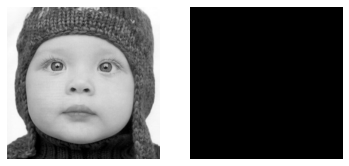

In [15]:
output = np.zeros((h, w, 1), dtype=np.uint8)
for i in range(h):
    for j in range(w):
        output[i, j, 0] = int(buf[i * w + j] & 0xFF)

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(output, cmap="gray")
plt.axis("off")
plt.show()